**What I want to do:** Get suburb information from microburbs (fantastic site btw) and understand which place would be ideal for us to move next.

Microburbs is a fantastic site that has aggregated useful information from several government sources as well as made intelligent derivations (pretty much what I would have done with the raw information - only more detailed and smarter!). However, the only way to see information in microburbs is through a map hover feature which makes it really hard to see and compare information from  all the surrounding suburbs of my suburb of interest. So let me get information of all the suburbs and then simply compare them side by side.

## 1. Admin stuff

In [1]:
import bs4
from bs4 import BeautifulSoup
from urllib2 import urlopen
import pandas as pd
import re
import numpy as np
from time import sleep
%matplotlib inline
import pylab as plt
import os
import warnings
import time

## 2. Source suburb html

I hovered over the inner west region of Sydney in microburbs.com.au and got the areas-list element upon inspection. Will go ahead and store this in a variable and extract info from the html.

In [2]:
baseid = 'https://www.microburbs.com.au'

In [3]:
# open the file and read as a single buffer. Close the file after reading successfully
fd = open('dict_burb_html', 'r')
cache = fd.read()
fd.close()

In [4]:
# this line of code splits ther html I've collected into burb locations. What I want to do is mine the html and collect burbids and burblinks
dict_burb_html = cache.replace('\n','').split(',')

## 3. Mine html and get the burbids/burblinks

In [5]:
# write a function for this:
def get_burbid_and_burblink(location, html_codedump, baseid = 'https://www.microburbs.com.au'):
    soup = BeautifulSoup(html_codedump, "lxml")
    burbid=[]; burblink = []
    for a in soup.find_all('a', href=True):
        burbid.append(a.string.string.encode('utf-8'))
        burblink.append(a['href'])
    df_temp = pd.DataFrame({'location':[location for x in burbid],'burbid':burbid,'burblink':burblink})
    df_temp['burblink'] = df_temp['burblink'].apply(lambda x: baseid+x)
    return df_temp

In [6]:
df_burbs = pd.DataFrame()
for burb in dict_burb_html:
    df_burbs = pd.concat((df_burbs, get_burbid_and_burblink(burb.split('|')[0],burb.split('|')[1])))

In [7]:
df_burbs.shape

(300, 3)

In [8]:
#df_burbs.burbid = pd.to_numeric(df_burbs.burbid, errors='coerce').fillna(0).astype(np.int64)

In [9]:
# change burb dataframe index
df_burbs.set_index('burbid',inplace=True)

In [10]:
pd.options.display.max_colwidth = 100
df_burbs.tail()

,burblink,location
burbid,,
1137521,https://www.microburbs.com.au/NSW/Sydney-Southern-suburbs/City-of-Rockdale/Bardwell-Park/1137521,Bardwell Park near station
1137522,https://www.microburbs.com.au/NSW/Sydney-Southern-suburbs/City-of-Rockdale/Bardwell-Valley/1137522,Bardwell Park near station
1137529,https://www.microburbs.com.au/NSW/Sydney-Southern-suburbs/City-of-Rockdale/Bardwell-Valley/1137529,Bardwell Park near station
1137728,https://www.microburbs.com.au/NSW/Sydney-Southern-suburbs/City-of-Rockdale/Bardwell-Park/1137728,Bardwell Park near station
1137731,https://www.microburbs.com.au/NSW/Sydney-Southern-suburbs/City-of-Rockdale/Bardwell-Park/1137731,Bardwell Park near station


In [11]:
pd.options.display.max_colwidth = 200
df_burbs.burblink.head(8)

burbid
1139512    https://www.microburbs.com.au/NSW/Sydney/Inner-West/Ashfield-Municipality/Summer-Hill-%28Ashfield----NSW%29/1139512
1139514    https://www.microburbs.com.au/NSW/Sydney/Inner-West/Ashfield-Municipality/Summer-Hill-%28Ashfield----NSW%29/1139514
1139501    https://www.microburbs.com.au/NSW/Sydney/Inner-West/Ashfield-Municipality/Summer-Hill-%28Ashfield----NSW%29/1139501
1139502    https://www.microburbs.com.au/NSW/Sydney/Inner-West/Ashfield-Municipality/Summer-Hill-%28Ashfield----NSW%29/1139502
1139516    https://www.microburbs.com.au/NSW/Sydney/Inner-West/Ashfield-Municipality/Summer-Hill-%28Ashfield----NSW%29/1139516
1139511    https://www.microburbs.com.au/NSW/Sydney/Inner-West/Ashfield-Municipality/Summer-Hill-%28Ashfield----NSW%29/1139511
1139509    https://www.microburbs.com.au/NSW/Sydney/Inner-West/Ashfield-Municipality/Summer-Hill-%28Ashfield----NSW%29/1139509
1139520    https://www.microburbs.com.au/NSW/Sydney/Inner-West/Ashfield-Municipality/Summer-Hill-%28Ashf

## 4. Mine suburb scores using links and ids

In [12]:
def get_burb_scores(burblink,burbid):
    html = urlopen(burblink).read()  
    soup = BeautifulSoup(html, 'lxml')
    dict={}
    for targetElements in soup.findAll('div', attrs = {'class' : 'col-sm-6 col-lg-5'}):
        for individual_score in targetElements.findAll('span', attrs = {'class' : 'human-score-value'}):
            dict[individual_score.parent.find('span', attrs = {'class' : 'title'}).text.strip().encode('utf-8')]=int(individual_score.text.strip().encode('utf-8'))
    return pd.DataFrame(dict, index=[burbid])

In [48]:
df_info = pd.DataFrame()
#***************************************************************************
#Commenting out the next few lines because this was a one time activity
# I'll read from the csv for all subsequent runs
# counter = 0
# for rowid,row in df_burbs.iterrows():
#     df_info = pd.concat([df_info,get_burb_scores(row['burblink'], rowid)])
#     counter+=1
#     if counter%10 == 0:
#         print (counter,' records completed...')
#     time.sleep(10)
# df_info.to_csv('burb_scores',index=True,header=True)
df_scores = pd.read_csv('burb_scores', index_col=0)

In [49]:
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 1139512 to 1141554
Data columns (total 9 columns):
Affluence Score         148 non-null int64
Communications Score    148 non-null int64
Community Score         147 non-null float64
Convenience Score       147 non-null float64
Family Score            144 non-null float64
Hip Score               147 non-null float64
Lifestyle Score         147 non-null float64
Safety Score            148 non-null int64
Tranquillity Score      147 non-null float64
dtypes: float64(6), int64(3)
memory usage: 11.6 KB


In [50]:
df_scores.head()

,Affluence Score,Communications Score,Community Score,Convenience Score,Family Score,Hip Score,Lifestyle Score,Safety Score,Tranquillity Score
1139512,9,9,9.0,9.0,8.0,9.0,9.0,3,7.0
1139514,9,9,9.0,9.0,9.0,8.0,9.0,3,7.0
1139501,10,9,9.0,9.0,10.0,8.0,9.0,5,8.0
1139502,10,9,9.0,9.0,9.0,8.0,9.0,3,8.0
1139516,10,9,10.0,9.0,10.0,8.0,9.0,3,8.0


In [54]:
df_combined = pd.merge(left=df_burbs,right=df_scores,how='inner',left_index=True,right_index=True)
df_combined[df_combined['Safety Score']>7].location.value_counts()

Mosman near wharf              10
Macmohans poimnt near wharf     3
Name: location, dtype: int64

## 5. Explore html element for prices

I'm happy with the dict approach. I should be able to map local prices as well as ethcicity by the same token.

In [12]:
def get_localprices_ethnicity_scores(burb_full_link, burbid):
    # get the rendered html 
    driver.get(burb_full_link)
    time.sleep(10)
    html2=driver.page_source
    
    # read all the tables present in the rendered link
    tables = pd.read_html(html2, flavor='bs4')
    
    # get local prices
    df_houseprice = tables[1].pivot_table(columns=tables[1].columns[0],aggfunc='first').reset_index(drop=True).dropna(how='all').head(1) 
    
    # get rental yield info
    df_rent = tables[2].pivot_table(columns=tables[1].columns[0],aggfunc='first').reset_index(drop=True).dropna(how='all').head(1) 

    # get ethnicity info
    df_ethnicity = tables[8].pivot_table(columns=tables[1].columns[0],aggfunc='first').reset_index(drop=True).dropna(how='all').head(1) 

    # put burbid info as a separate datafframe in order to concatenate later
    df_id = pd.DataFrame({'id':[str(burbid)]})

    # the next couple of lines of code get the corresponding scores for the id
    dict={}
    soup = BeautifulSoup(html2, 'lxml')
    for targetElements in soup.findAll('div', attrs = {'class' : 'col-sm-6 col-lg-5'}):
        for individual_score in targetElements.findAll('span', attrs = {'class' : 'human-score-value'}):
            dict[individual_score.parent.find('span', attrs = {'class' : 'title'}).text.strip().encode('utf-8')]=int(individual_score.text.strip().encode('utf-8'))
    df_scores = pd.DataFrame(dict, index=[str(burbid)])

    df_info=pd.DataFrame()
    df_info = pd.concat([df_houseprice,df_rent,df_ethnicity,df_id], axis=1)
    df_info.set_index('id',inplace=True)
    df_info = pd.concat([df_scores, df_info], axis=1)
    
    return df_info

## 6. Get them all into a dataframe

In [13]:
# df_info = pd.DataFrame()
# df_exceptions = pd.DataFrame()
# from selenium import webdriver

# counter = 0
# for rowid,row in df_burbs.iterrows():
#     if counter%3 == 0:
#         # the options disable geolocation
#         options = webdriver.ChromeOptions()
#         prefs = {"profile.default_content_setting_values.geolocation" :2}
#         options.add_experimental_option("prefs",prefs)
#         driver = webdriver.Chrome(chrome_options=options)
#         time.sleep(10)
#     try:
#         df_info = pd.concat([df_info,get_localprices_ethnicity_scores(row['burblink'], rowid)])
#     except:
#         df_exceptions = pd.concat([df_exceptions,pd.DataFrame({'link':row['burblink']},index=[str(rowid)])])
#         print ("skipping burbid:",rowid)
#         pass
#     counter+=1
#     if counter%3 == 0:
#         driver.close()
#     if counter%10 == 0:
#         print (counter,' records completed...')
#     time.sleep(10)

# df_info.to_csv('entire_burb_info',index=True,header=True)
# df_exceptions.to_csv('entire_burb_exceptions',index=True,header=True)
df_info = pd.read_csv('entire_burb_info', dtype={'id':object})
df_info.set_index('id',inplace=True)

## 7. Merge scores and prices with the annotation

In [14]:
df_combined = pd.merge(left=df_burbs, right=df_info, how='left', left_index=True, right_index=True)
df_combined.tail()

,burblink,location,Affluence Score,Alternative therapies,Ancestry,Art,Bicycle Commuters,Body & Ear Piercing,Coffee shops,Communications Score,...,Price per sqm,Pubs,Restaurants,Safety Score,Single Men,Single Women,Tattoo parlours,Tranquillity Score,Uni Students,Unit price growth (2013-2016)
1152425,https://www.microburbs.com.au/NSW/Sydney-Western-suburbs/City-of-Liverpool/Wattle-Grove-%28NSW%29/1152425,Holsworthy near station,9.0,NaN,Australian 18% English 15% 18 more Italian 7% Indian 6% Lebanese 5% Chinese 4% Vietnamese 4% Irish 4% Serbian 3% Scottish 3% Filipino 3% Greek 2% Maltese 2% German 2% ...,NaN,NaN,NaN,NaN,9.0,...,"$1,350",NaN,NaN,9.0,NaN,NaN,NaN,9.0,NaN,NaN
1152430,https://www.microburbs.com.au/NSW/Sydney-Western-suburbs/City-of-Liverpool/Hammondville/1152430,Holsworthy near station,7.0,NaN,NaN,NaN,0% of workers,NaN,NaN,9.0,...,"$1,350",NaN,NaN,9.0,16%,10%,NaN,9.0,4%,NaN
1152431,https://www.microburbs.com.au/NSW/Holsworthy/1152431,Holsworthy near station,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1152434,https://www.microburbs.com.au/NSW/Holsworthy/1152434,Holsworthy near station,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1152438,https://www.microburbs.com.au/NSW/Holsworthy/1152438,Holsworthy near station,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 8. Analyse this

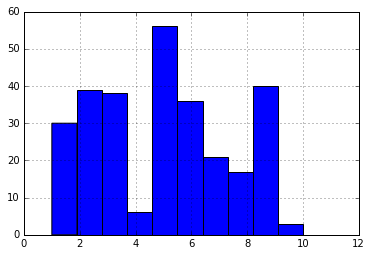

In [29]:
df_combined['Safety Score'].hist()

In [35]:
df_combined.groupby(by='location')['Safety Score'].median().sort_values()

location
Central_near_gym               1.0
Redfern near station           1.0
Erko_near_station              2.0
Macdonaldtown near station     2.0
Newtown near station           2.0
Marrickville near station      3.0
Petersham near station         3.0
Stanmore_near_station          5.0
Lewisham near station          5.0
Summer Hill near station       5.0
Mascot near station            5.0
Artarmon near station          6.0
Wolli creek near Nisch         6.0
Neutral Bay near wharf         7.0
Rhodes near Poovi              7.0
Macmohans poimnt near wharf    7.5
Holsworthy near station        9.0
Concorde near station          9.0
Bardwell Park near station     9.0
Mosman near wharf              9.0
Name: Safety Score, dtype: float64

In [15]:
df_combined.to_csv('df_combined.csv',index=True,header=True)